# Problema de Titanic - Rappi


El famoso problema de TItanic consiste en, a partir de datos de los individuos involucrados en el accidente, predecir quienes se salvaron y quienes no.

En este notebook usaremos la libreria Titanic-Fairy para entrenar un modelo que pueda resolver el problema

# Datos

Los datos de la tabla que se usara de entrenamiento se puede resumir en la siguiente tabla 

| Column Name - customers.csv | Description |
|:--|:--|
| Survival | Survival (0 = No; 1 = Yes). Not included in test.csv file | 
| Pclass |  Ticket Class/ A Proxy for socio-economic status(SES) (1 = 1st/Upper ; 2 = 2nd/Middle; 3 = 3rd/Lower) | 
| Name | Name |
| Sex | Sex |
| Age | Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5 |
| Sibsp | Number of Siblings (brother, sister, stepbrother, stepsister) /Spouses (husband, wife (mistresses and fiancés were ignored)) Aboard |
| Parch | Number of Parents (mother, father)/Children (daughter, son, stepdaughter, stepson) Aboard; Some children travelled only with a nanny, therefore parch=0 for them. |
| Ticket | Ticket Number |
| Fare | Passenger Fare |
| Cabin | Cabin |
| Embarked | Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton) |

A continuacion veamos como se correlacionan algunas de estas variables

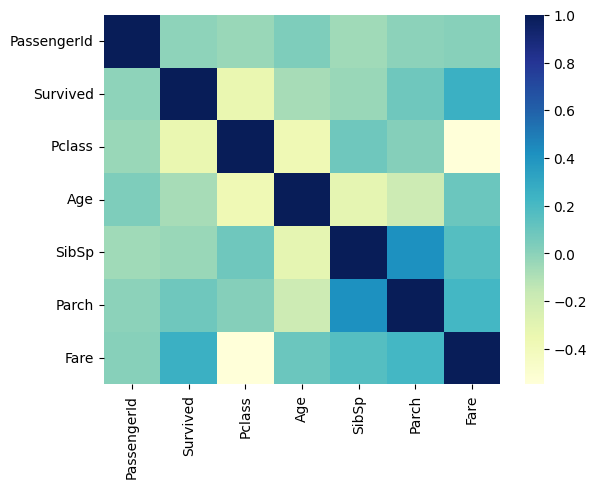

In [1]:
from titanic_fairy.helpers.load_and_save import Load
from titanic_fairy.helpers.train_test_split import stratified_split
from titanic_fairy.metrics.graphics import show_heatmap, check_train_test_split

titanic_raw_train = Load(train_path = "../dataset/train.csv")
show_heatmap(titanic_raw_train)

A primera vista, la clase y el precio del ticekt parecen influir en la supervivencia. No se ven efectos en la edad, pero esto puede deberse a un problema de escala de las variables. 

Con esto en mente reliazemos la separacion entre Train y Test. Consideramos la posibillidad de clases desbalanceadas, por lo tanto ocupamos una separacion estratificada en base a Sexo, Pclass y Supervivencia. 

En la siguiente grafica se observa que la separacion es efectivamente balanceada.


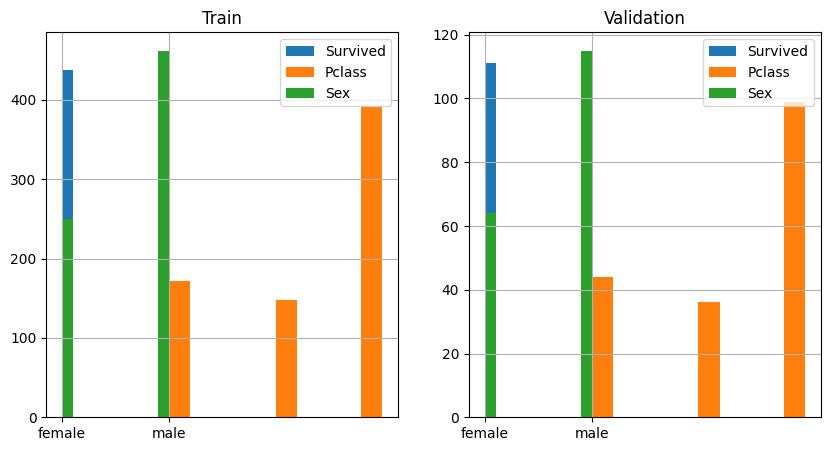

In [2]:
raw_train, raw_test = stratified_split(titanic_raw_train)

check_train_test_split(raw_train, raw_test)

# Preprocesamiento

Notemos lo siguiente

In [3]:
raw_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 10 to 407
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          573 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        163 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


In [4]:
raw_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            139
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          549
Embarked         2
dtype: int64

El preprocesamiento se llevara a cabo en 3 fases:

- Imputacion

Hay valores nulos en edad, cabina y embarcacion.Imputaremos estos datos (Usando promedio y la moda). Ademas necesitamos codificar correctamente la cabina,  

- Codificacion

Embarked y Sex corresponden a variables categoricas. Usaremos One-Shot-Encoding para este proposito.

- Eliminacion

Notemos que los datos de Cabina falltantes representan mucho mas del 50% de los datos, por lo que conviene desecharlos realmente. Tambien desecharemos el ID, el nombre y el ticket. El nombre puede entregar alguna info ("Mr." o "Mrs." por ejemplo ) pero asumiremos que esta informacion ya esta dentro de las otras variables (Tarifa y sexo por ejemplo). 


Estos tres pasos se peuden realizar con el wrapper de preprocesamiento de la libreria


In [5]:
raw_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
461,462,0,3,"Morley, Mr. William",male,34.0,0,0,364506,8.0500,NaN,S
738,739,0,3,"Ivanoff, Mr. Kanio",male,NaN,0,0,349201,7.8958,NaN,S
437,438,1,2,"Richards, Mrs. Sidney (Emily Hocking)",female,24.0,2,3,29106,18.7500,NaN,S
47,48,1,3,"O'Driscoll, Miss. Bridget",female,NaN,0,0,14311,7.7500,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
722,723,0,2,"Gillespie, Mr. William Henry",male,34.0,0,0,12233,13.0000,NaN,S
464,465,0,3,"Maisner, Mr. Simon",male,NaN,0,0,A/S 2816,8.0500,NaN,S
85,86,1,3,"Backstrom, Mrs. Karl Alfred (Maria Mathilda Gu...",female,33.0,3,0,3101278,15.8500,NaN,S
586,587,0,2,"Jarvis, Mr. John Denzil",male,47.0,0,0,237565,15.0000,NaN,S


In [6]:
from titanic_fairy.preprocessing.preprocess import Preprocess

preproc_train = Preprocess().fit_transform(raw_train)
preproc_test = Preprocess().fit_transform(raw_train)

In [7]:
from titanic_fairy.model.train_model import build_model
from titanic_fairy.enums.titanic_fields import Fields, Preprocess_


X_train = preproc_train.drop([Fields.Survived.value], axis=1)
y_train = preproc_train[Fields.Survived.value]

X_test = preproc_test.drop([Fields.Survived.value], axis=1)
y_test = preproc_test[Fields.Survived.value]



model = build_model(X_train, y_train)


In [8]:
X_test = preproc_test.drop([Fields.Survived.value], axis=1)
y_test = preproc_test[Fields.Survived.value]

import numpy as np

model.score(X_test, y_test)

0.8455056179775281

In [10]:
model.predict(X_test).flatten()

array([1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,